### Description
In this notebook, as there're 100+ zips in SD county, we try to cluster zips based on various transaction characteristics. This serves as both EDA on housing market and segmentation method for modeling of price estimation.
* Clustering on price
  * clustering on sqft_price gives natural groups based on price level.
  * clustering on sqft_price difference or YoY generated groups representing similar appreciation/depreciation patterns.
* clustering on volume
  * Volume pattern is usually aligned with neighborhood history, it's expected to see surge when the neighborhood has lots of new construction and development.
  * Well established and new neighborhood should show different patterns.
  * Expensive and low-price neighborhoods should show different patterns.

In [1]:
%load_ext autoreload
%autoreload 1
import os,sys
import numpy as np
import pandas as pd

src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *
%aimport model_manage
from model_manage import *
%aimport algorithm
from algorithm import *

import logging
from utils import *
set_logger(logging.WARNING)

In [2]:
from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

### load data
* all transactions (1983~2017.10) and features of properties involved in these transactions
* all properties with 

In [3]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
df_transaction = ds.get_view_df('property_address_school_transactions')
df_property = ds.get_view_df('property_address_schools')
print(df_transaction.shape)
print(df_property.shape)

(1477830, 37)
(710576, 34)


In [4]:
pp = Preprocess(df_transaction, df_property)
use_features = pp.get_feature_list()
school_features = ['min_elem_distance', 'min_middle_distance', 'min_high_distance',
                   'elem_rating', 'middle_rating', 'high_rating',
                   'avg_elem_rating', 'avg_high_rating', 'avg_middle_rating']
use_features = list(set(use_features ) - set(school_features))
df_all = pp.dataset(feature='all', valid=True)

## clustering zips based on transaction sqft_price series

### data preparation
For each zip
* get median sqft_price and volume series for all years.
* Need clean the data by thresholding with certain volume level, if volume is below threshold for some zip at some year, the value is replaced with null. This operation is because the median sqft_price series has too much noise if according volume is too low.
* If zip has too many null values in its series, it's filtered out as it doesn't have enough data for this analysis.
* For valid zips, interpolate to fill the null values from series.

In [5]:
zip_counts = df_all['zip'].value_counts()
sqft_price_series = df_all.groupby(by=['zip','sold_year'])['sqft_price'].median().unstack(level=-1)
trans_count_series = df_all.groupby(by=['zip','sold_year'])['sqft_price'].count().unstack(level=-1)

In [6]:
T_trans_count = 40  # threshold volume
T_null = 8  # threshold of null values to drop the zip
sqft_price_series_filter = sqft_price_series[trans_count_series > T_trans_count]
sqft_price_series_valid = sqft_price_series_filter[sqft_price_series_filter.isnull().sum(axis=1) < T_null]
sqft_price_series_invalid = sqft_price_series_filter[sqft_price_series_filter.isnull().sum(axis=1) >= T_null]
print('Got valid zip count:', sqft_price_series_valid.shape[0])
print('Dropped invalid zip count:', sqft_price_series_invalid.shape[0])
print('For valid zips, print their null values histogram:\nnull count, zip count')
print(sqft_price_series_valid.isnull().sum(axis=1).value_counts())
#sqft_price_series_invalid.isnull().sum(axis=1).value_counts()

zips_valid = sqft_price_series_valid.index

trans_count_series_valid = trans_count_series[sqft_price_series_filter.isnull().sum(axis=1) < T_null]
trans_count_series_filled = trans_count_series_valid.copy().fillna(0)

Got valid zip count: 80
Dropped invalid zip count: 20
For valid zips, print their null values histogram:
null count, zip count
0    75
2     2
4     1
3     1
1     1
dtype: int64


In [7]:
# interpolate to fill null
sqft_price_series_filled = sqft_price_series_valid.interpolate(method='akima', axis=1)
# need fill the missing beginning since interpolation can't fill beginning
sqft_price_series_filled = sqft_price_series_filled.fillna(sqft_price_series_filled.median())

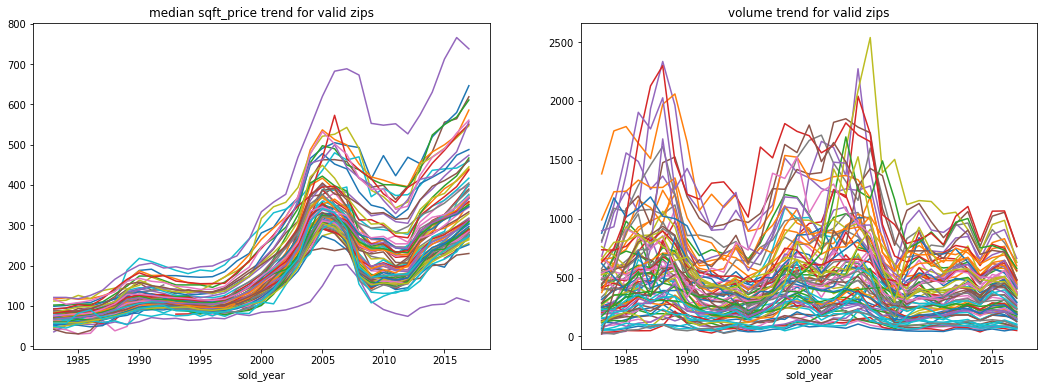

In [8]:
fig, ax = plt.subplots(1,2, figsize=(18,6))
for zip in sqft_price_series_valid.index:
    ax[0].set_title("median sqft_price trend for valid zips")
    sqft_price_series_valid.loc[zip].plot(ax=ax[0], kind='line', label=zip)
    ax[1].set_title("volume trend for valid zips")
    trans_count_series_valid.loc[zip].plot(ax=ax[1], kind='line', label=zip)
plt.show()

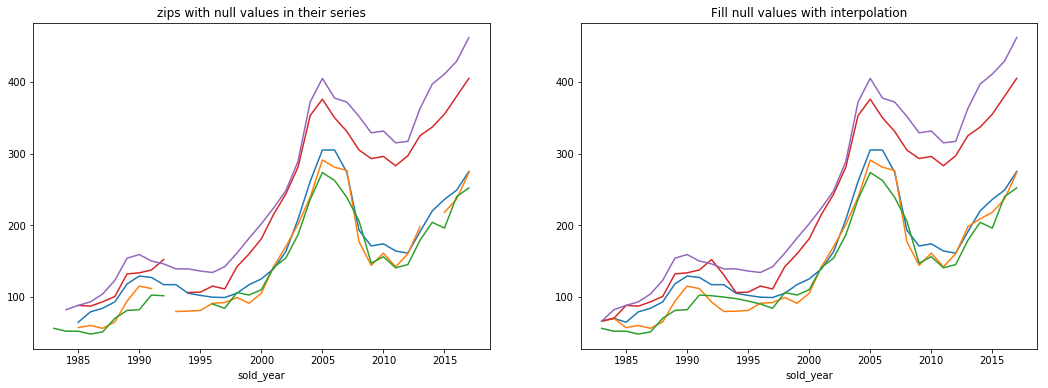

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))
for zip in sqft_price_series_valid.index:
    if sqft_price_series_valid.loc[zip].isnull().sum() == 0: continue
    ax[0].set_title("zips with null values in their series")
    sqft_price_series_valid.loc[zip].plot(ax=ax[0], kind='line', label=zip)
    ax[1].set_title("Fill null values with interpolation")
    sqft_price_series_filled.loc[zip].plot(ax=ax[1], kind='line', label=zip)
plt.show()

### correlation of sqft_price series
* To see if zips' sqft_price series are strongly correlated(zips have similar trend) or can they be differentiated
* look at 3 series
 * sqft_price series
 * series of sqft_price difference between current year and last year
 * eries of sqft_price YoY percentage.

In [10]:
# prepare data - get difference series and YoY series
import sklearn.covariance as covariance
def get_series_diff(df_complete):
    series_next = df_complete[df_complete.columns[1:]]
    series_prev = df_complete[df_complete.columns[:-1]].copy()
    series_prev.columns = series_next.columns
    series_diff = series_next - series_prev
    series_yoy = series_diff / series_prev
    return series_diff, series_yoy

sqft_price_series_diff,sqft_price_series_yoy = get_series_diff(sqft_price_series_filled)

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = sqft_price_series_filled.copy().T
X /= X.std(axis=0)
corr = X.corr()

X = sqft_price_series_diff.copy().T
X /= X.std(axis=0)
corr_diff = X.corr()

X = sqft_price_series_yoy.copy().T
X /= X.std(axis=0)
corr_yoy = X.corr()

Text(0.5,1,'zip sqft_price YoY series correlation')

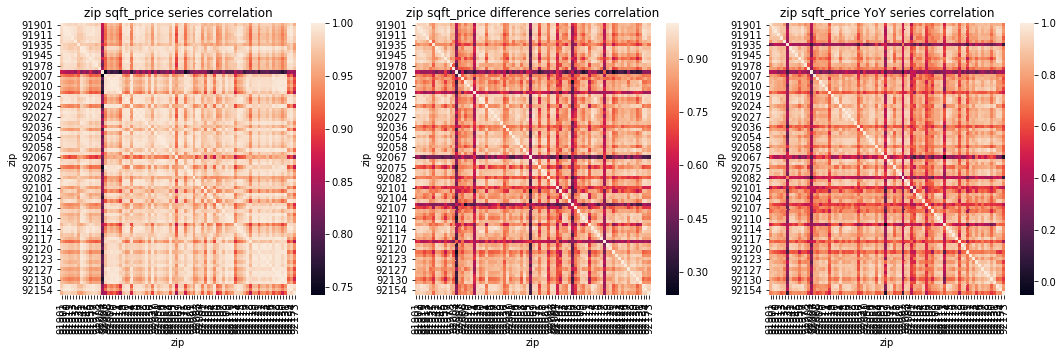

In [11]:
import seaborn as sns
fig, ax = plt.subplots(1, 3, figsize=(18,5))
sns.heatmap(corr, ax=ax[0], xticklabels=zips_valid)
ax[0].set_title('zip sqft_price series correlation')
sns.heatmap(corr_diff, ax=ax[1], xticklabels=zips_valid)
ax[1].set_title('zip sqft_price difference series correlation')
sns.heatmap(corr_yoy, ax=ax[2], xticklabels=zips_valid)
ax[2].set_title('zip sqft_price YoY series correlation')

#### findings
* sqft_price series(left image) shows most zips are highly correlated, meaning zips have very similar sqft_price trending, except one zip of the black line.
* difference series start to differentiate zips
* YoY series differentiate more, means zips apreciate and depreciate in different rates.

### clustering zips
* Cluster on sqft_price series, sqft_price diff series, sqft_price YoY series
* Different cluster algorithm: affinity propagation, spectral clustering, GMM

C:\Users\wenyan\Anaconda3\envs\cap\lib\site-packages\sklearn\cluster\spectral.py:442: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


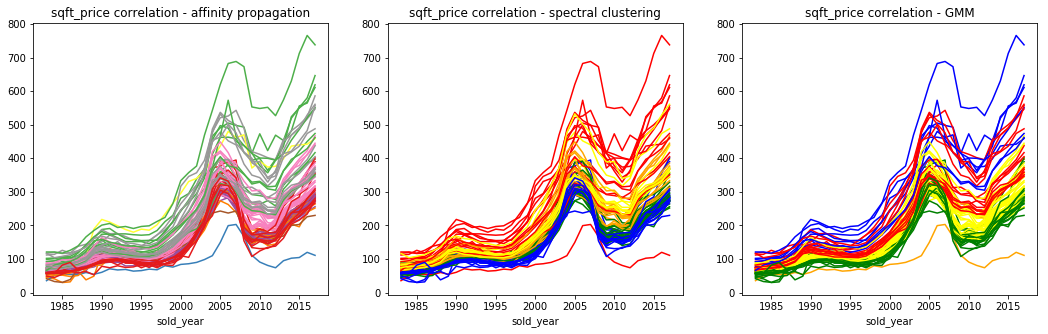

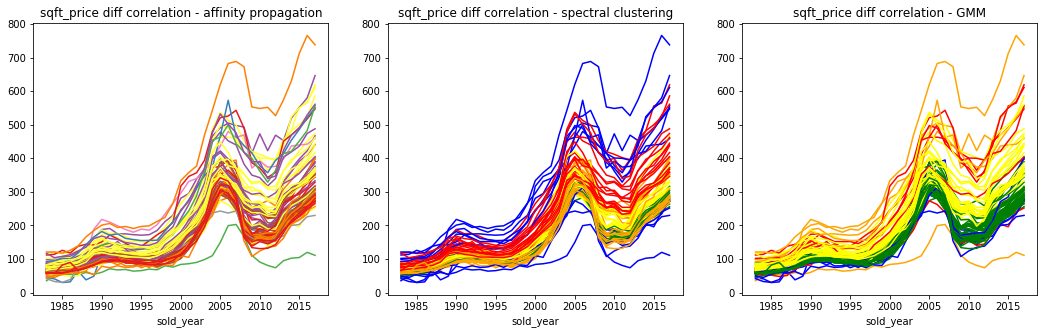

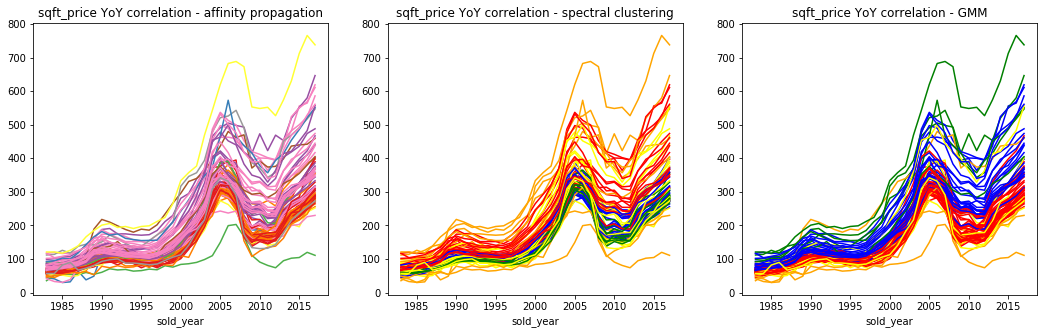

In [16]:
from sklearn import cluster
from sklearn import mixture

def cluster_trend(df_series, clusters=5, feature=''):
    labels = {}
    # Cluster using affinity propagation
    _, labels['affinity'] = cluster.affinity_propagation(df_series)

    # spectral clustering
    spectral = cluster.SpectralClustering(n_clusters=clusters, eigen_solver='arpack', affinity="nearest_neighbors")
    spectral.fit(df_series)
    labels['spectral'] = spectral.labels_

    # GMM
    gmm = mixture.GaussianMixture(n_components=clusters, covariance_type='full')
    gmm.fit(df_series)
    labels['gmm'] = gmm.predict(df_series)

    fig, ax = plt.subplots(1, 3, figsize=(18,5))

    plot_trend_cluster(sqft_price_series_filled, labels['affinity'], ax[0], feature +' - affinity propagation')
    plot_trend_cluster(sqft_price_series_filled, labels['spectral'], ax[1], feature + ' - spectral clustering')
    plot_trend_cluster(sqft_price_series_filled, labels['gmm'], ax[2], feature + ' - GMM')
    plt.show()
    
    return labels

labels = cluster_trend(corr, 5, 'sqft_price correlation')
labels = cluster_trend(corr_diff, 5,'sqft_price diff correlation')
labels = cluster_trend(corr_yoy, 5, 'sqft_price YoY correlation')

clustering results - sqft_price series:
Cluster 0 (red): 91901, 91902, 91910, 91911, 91913, 91935, 91945, 91950, 91977, 91978, 92003, 92019, 92020, 92021, 92025, 92026, 92027, 92028, 92029, 92036, 92040, 92056, 92057, 92058, 92065, 92069, 92071, 92078, 92081, 92082, 92083, 92084, 92105, 92113, 92114, 92139, 92154, 92173
Cluster 1 (green): 92007, 92014, 92037, 92067, 92075, 92101, 92103, 92106, 92107, 92109
Cluster 2 (orange): 91932, 91941, 91942, 92009, 92010, 92054, 92064, 92102, 92108, 92110, 92111, 92115, 92119, 92120, 92123, 92124, 92126, 92127, 92128, 92129, 92131
Cluster 3 (blue): 92118
Cluster 4 (yellow): 92004
Cluster 5 (purple): 92008, 92011, 92024, 92104, 92116, 92117, 92121, 92122, 92130

clustering results - sqft_price diff series:
Cluster 0 (red): 91978, 92007, 92009, 92010, 92011, 92024, 92037, 92064, 92075, 92103, 92104, 92107, 92109, 92110, 92111, 92117, 92119, 92121, 92122, 92123, 92124, 92126, 92128, 92129, 92130, 92131
Cluster 1 (green): 91950, 92102, 92106, 92113
Cl

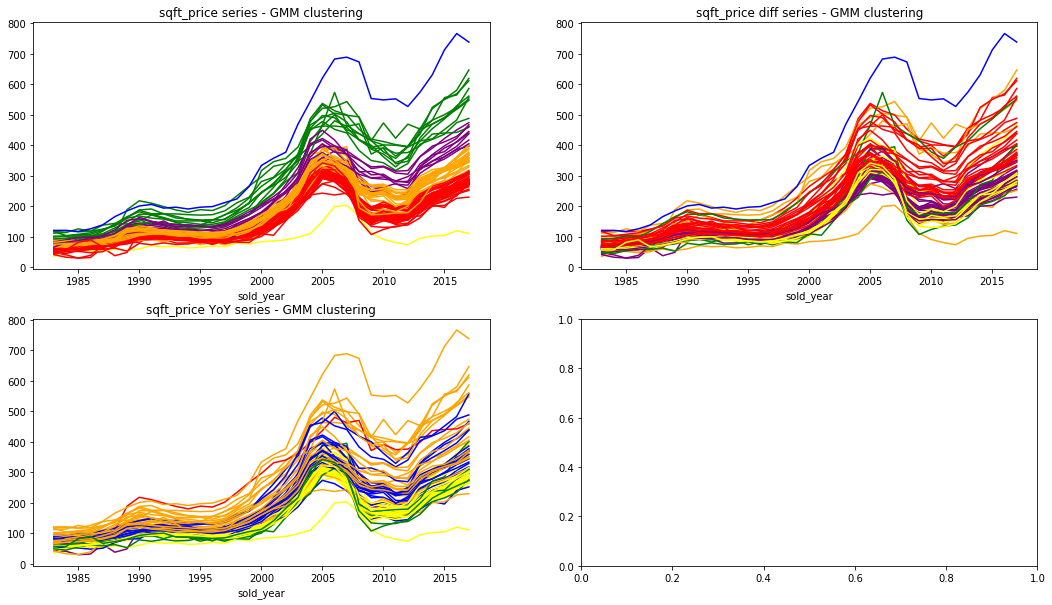

In [43]:
fig, ax = plt.subplots(2, 2, figsize=(18,10))
gmm = mixture.GaussianMixture(n_components=6, covariance_type='full')
gmm.fit(sqft_price_series_filled)
cluster_price = gmm.predict(sqft_price_series_filled)
print("clustering results - sqft_price series:")
plot_trend_cluster(sqft_price_series_filled, cluster_price, ax[0,0], 'sqft_price series - GMM clustering', True)

gmm = mixture.GaussianMixture(n_components=6, covariance_type='full')
gmm.fit(sqft_price_series_diff)
cluster_price_diff = gmm.predict(sqft_price_series_diff)
print("\nclustering results - sqft_price diff series:")
plot_trend_cluster(sqft_price_series_filled, cluster_price_diff, ax[0,1], 'sqft_price diff series - GMM clustering', True)

gmm = mixture.GaussianMixture(n_components=6, covariance_type='full')
gmm.fit(sqft_price_series_yoy)
cluster_yoy = gmm.predict(sqft_price_series_yoy)
print("\nclustering results - sqft_price YoY series:")
plot_trend_cluster(sqft_price_series_filled, cluster_yoy, ax[1,0], 'sqft_price YoY series - GMM clustering', True)

### volume trending

Cluster 0 (red): 91901, 91902, 91932, 91935, 91941, 91945, 91950, 91978, 92003, 92004, 92007, 92008, 92010, 92014, 92029, 92036, 92058, 92065, 92067, 92075, 92082, 92083, 92102, 92103, 92104, 92105, 92106, 92107, 92110, 92113, 92116, 92118, 92119, 92121, 92123, 92124, 92173
Cluster 1 (green): 92056, 92057, 92126, 92128, 92129
Cluster 2 (orange): 91910, 91911, 91942, 91977, 92011, 92019, 92020, 92021, 92024, 92025, 92026, 92027, 92028, 92037, 92040, 92054, 92064, 92069, 92071, 92081, 92084, 92108, 92109, 92111, 92114, 92115, 92117, 92120, 92122, 92131, 92139, 92154
Cluster 3 (blue): 91913, 92009, 92078, 92101, 92127, 92130


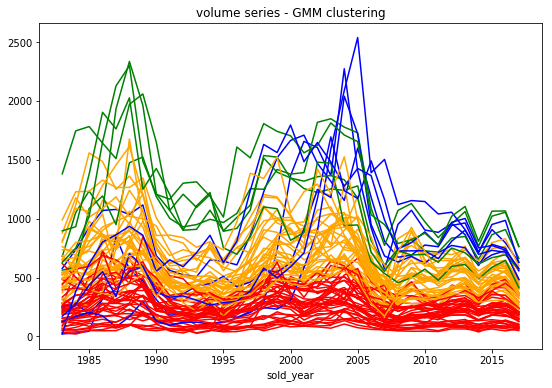

In [42]:
gmm = mixture.GaussianMixture(n_components=4, covariance_type='full')
gmm.fit(trans_count_series_filled)
cluster_volume = gmm.predict(trans_count_series_filled)
plot_trend_cluster(trans_count_series_valid, cluster_volume, None, 'volume series - GMM clustering', True)

In [82]:
df_clusters = pd.DataFrame({'cluster_on_sqft_price': cluster_price, 'cluster_on_sqft_price_diff': cluster_price_diff, 'cluster_on_sqft_price_yoy': cluster_yoy, 'cluster_on_volume':cluster_volume})
df_clusters.index = zips_valid
df_clusters.to_json('c:\projects\sdra\public\json\zip_clusters.json')

#### findings
* price
  * The clustering on sqft_price series produced natural segmentations of zips which can be easily understood as cheap, medium and expensive areas.
  * Clustering on YoY series helped identify some outstanding zips that behave quite different with others, eg 92121 is very resistant in crisis, and 92004 falls far behind of the whole market.
* volume
  * There were 2 surges of volume in certain zips at around 1987(in green color) and 2004(in blue). They're 2 construction periods in those zips.
  * The established neighborhoods have volumes relatively stable, the red zips are either of inactive housing market or very expensive housing price.

### future work - clustering heterogeneous dataset
Right now we only cluster on series with single feature, if we want to cluster on multiple features eg sqft_price and volume, 
we need come up with some meaningful distance function with the 2 features. 